In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

デバイス毎に音楽の再生音量の最大値は異なる．騒音の大きさから，再生音量を実数値( $0 \leq x \leq 1.0$ )で求める関数があると便利．  
デバッグ用 SC-04J 上でAudioRecoderで計測した音量の値（騒音）と，その時に設定した音楽の再生音量を，騒音500毎にまとめたデータを用意．  
回帰モデルにフィットさせて関数化する．

In [2]:
# データを読み込む
# 再生音量は SC-04J  では15段階中での整数値であり，これを 0　から1.0 までの実数値に射影する
df = pd.read_csv("data.csv", names=["騒音", "再生音量"])
df["再生音量（実数値）"] = df["再生音量"] / 15
df

,騒音,再生音量,再生音量（実数値）
0,11000,3,0.200000
1,10500,3,0.200000
2,10000,3,0.200000
3,9500,2,0.133333
4,9000,2,0.133333
5,8500,2,0.133333
6,8000,2,0.133333
7,7500,2,0.133333
8,7000,2,0.133333
9,6500,2,0.133333


Text(0,0.5,'play_level')

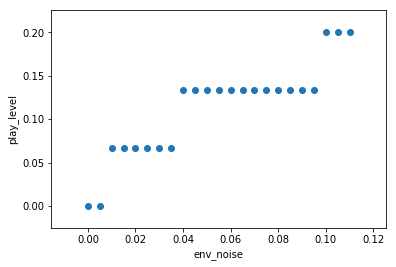

In [3]:
# 騒音値が10^3オーダ，再生音量が10^-1オーダなので，オーダを再生音量側に揃える
# プロット
x = df.loc[:,"騒音"] / 100000
y = df.loc[:,"再生音量（実数値）"]
plt.scatter(x, y)
plt.xlabel("env_noise")
plt.ylabel("play_level")

In [4]:
# a + bx にフィット
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
print(lr.score(np.array(x).reshape(-1, 1),y), lr.intercept_, lr.coef_)

# 周囲の騒音が大きいほど，音楽の音量を上げたくなるので，その点では妥当？

0.8187799043062202 0.03260869565217393 [1.46245059]


In [5]:
# 試しに a + bx + cx^2 にフィット
lr2 = LinearRegression().fit(np.dstack((np.power(np.array(x),2),np.array(x)))[0], y)
print(lr2.score(np.dstack((np.power(np.array(x),2),np.array(x)))[0],y), lr2.intercept_, lr2.coef_)

# センサの値はshort型の整数部分=0~32767 この2次関数は，2*10^4あたりで減少を始めてしまうので，実態にそぐわない

0.8389230652388547 0.01768115942028997 [-7.75456428  2.31545266]


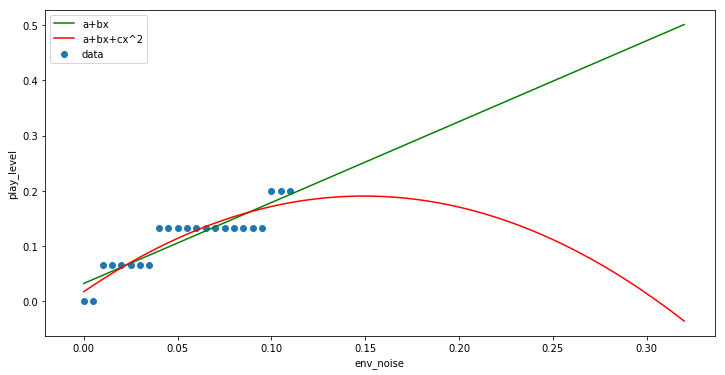

In [6]:
# グラフ描写
RNG = np.linspace(0, 0.32, 100)
plt.figure(figsize=(12,6))
plt.scatter(x, y, label="data")
plt.xlabel("env_noise")
plt.ylabel("play_level")
plt.plot(RNG, lr.intercept_ + lr.coef_ * RNG, label="a+bx", color="green")
plt.plot(RNG, lr2.intercept_ + lr2.coef_[1] * RNG + lr2.coef_[0] * RNG * RNG, label="a+bx+cx^2", color="red")
plt.legend(loc='upper left')

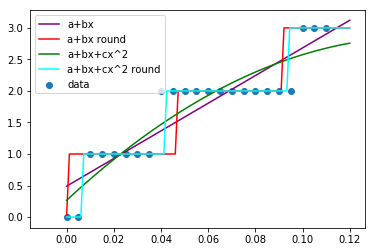

In [7]:
# 騒音から再生音量を求める関数を用いて，実際にデバイスの再生音量を決定してみる
# 関数の値を四捨五入して整数化

RNG = np.linspace(0, 0.12, 100)
DIV_NUM = 15  # デバイス毎に異なる，再生音量の最大値

plt.figure(figsize=(6, 4))
plt.scatter(x, df["再生音量"], label="data")
plt.plot(RNG, DIV_NUM * (lr.intercept_ + lr.coef_[0] * RNG), label="a+bx", color="purple")
plt.plot(RNG, np.round(DIV_NUM * (lr.intercept_ + lr.coef_[0] * RNG)), label="a+bx round", color="red")
plt.plot(RNG, DIV_NUM * (lr2.intercept_ + lr2.coef_[1] * RNG + lr2.coef_[0] * RNG * RNG), label="a+bx+cx^2", color="green")
plt.plot(RNG, np.round(DIV_NUM * (lr2.intercept_ + lr2.coef_[1] * RNG + lr2.coef_[0] * RNG * RNG)), label="a+bx+cx^2 round", color="cyan")
plt.legend(loc='upper left')

1次関数 $f_1(x)$ へのフィットは，全体では妥当だが，騒音xが $0 \leq x \leq 0.12$ ではおかしい．  
2次関数 $f_2(x)$ へのフィットは，騒音xが $0 \leq x \leq 0.12$の場合は元のデータに近い表現だが，全体ではおかしい．  
この2つの関数のいいとこ取りをした関数 $f_d(x) = $ ：  
$$
f_2(x) \ \ \ \ if \ x \ \leq 0.06  \\
\max(f_1(x), \ f_2(x)) \ \ \ \ otherwise  
$$
はどうだろうか．  
（右側の交点より左を2次関数，右側を1次関数にしたい）  

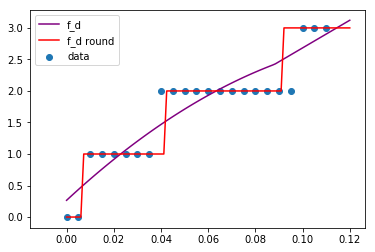

In [8]:
def f_d(x):
    if x <= 0.06:
        return lr2.intercept_ + lr2.coef_[1] * x + lr2.coef_[0] * x * x
    else:
        return max(lr.intercept_ + lr.coef_[0] * x, lr2.intercept_ + lr2.coef_[1] * x + lr2.coef_[0] * x * x)
    
plt.scatter(x, df["再生音量"], label="data")
plt.plot(RNG, DIV_NUM * np.frompyfunc(f_d,1,1)(RNG), label="f_d", color="purple")
plt.plot(RNG, np.round(DIV_NUM * np.frompyfunc(f_d,1,1)(RNG).astype(np.float32)), label="f_d round", color="red")
plt.legend(loc='upper left')

In [9]:
# まだズレてるけど前よりマシなので当面これを採用